### Abstract

Here we investigate how people adjust their behaviour to the underlying temporal structure of changes. For this purpose we have modified a standard reversal learning task to include exploratory (epistemic) choices, which participants can use to learn the correct choice on the current trial. Participants were separated in two groups, each group exposed to different experimental conditions characterised by a different temporal structure of reversals. The differences in experimental conditions is illustrated bellow.

To understand the interplay between beliefs about temporal structure and behaivour we have used an active inference agent based on hidden semi-Markov models, allowing us to model learning of temporal strucure, besides learning of choice outcome contingencies, and online inference of the hidden context.

We illustrate participants behaviour using two measures of performance, expected reward and trials until correct. 

Quanitfying the probability of exploratory choices at each trial relative to the moment of reversals we can identify distinct characteristic responses of behaviour in two experimental conditions. This results suggest that people are sensitive to the temporal structure of the reversals (they can learn it) and that they use this structure for infering most likely moments of reversals, as reflected in the statistics of exploratory choices.

In [1]:
# import packages and set environment
import sys
import os
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jax.nn import softmax

from matplotlib import cm, colors

from stats import trials_until_correct, trials_until_explore, running_mean, performance

from scipy import io

from jupyterthemes import jtplot

jtplot.style(theme='grade3', context='paper', fscale=1.6, grid=False)

# append current directory to sys path
cwd = os.getcwd()
sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

%matplotlib inline

In [2]:
# load experimental parameters
states_and_rewards = io.loadmat('main/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

In [3]:
# import data loader
from stats import load_data

# load behavioural data
outcomes_data, responses_data, mask_data, counts, correct_choices_data, conditions = load_data()

nsub, ns_reg, ns_irr = counts

pilot = conditions.experiment == 'pilot'
ns_pilot = sum(pilot)
ns_pilot_reg = sum( conditions.loc[pilot, 'condition'] == 'regular')
ns_pilot_irr = sum( conditions.loc[pilot, 'condition'] == 'irregular')
print(' Total number of subjects is {}, of which {} where asigned to regular condition and {} where tested during a pilot study (without exploration option). In the pilot study {} subjects where asigned to the regular condition.'.format(nsub, ns_reg, ns_pilot, ns_pilot_reg))

 Total number of subjects is 74, of which 41 where asigned to regular condition and 24 where tested during a pilot study (without exploration option). In the pilot study 14 subjects where asigned to the regular condition.


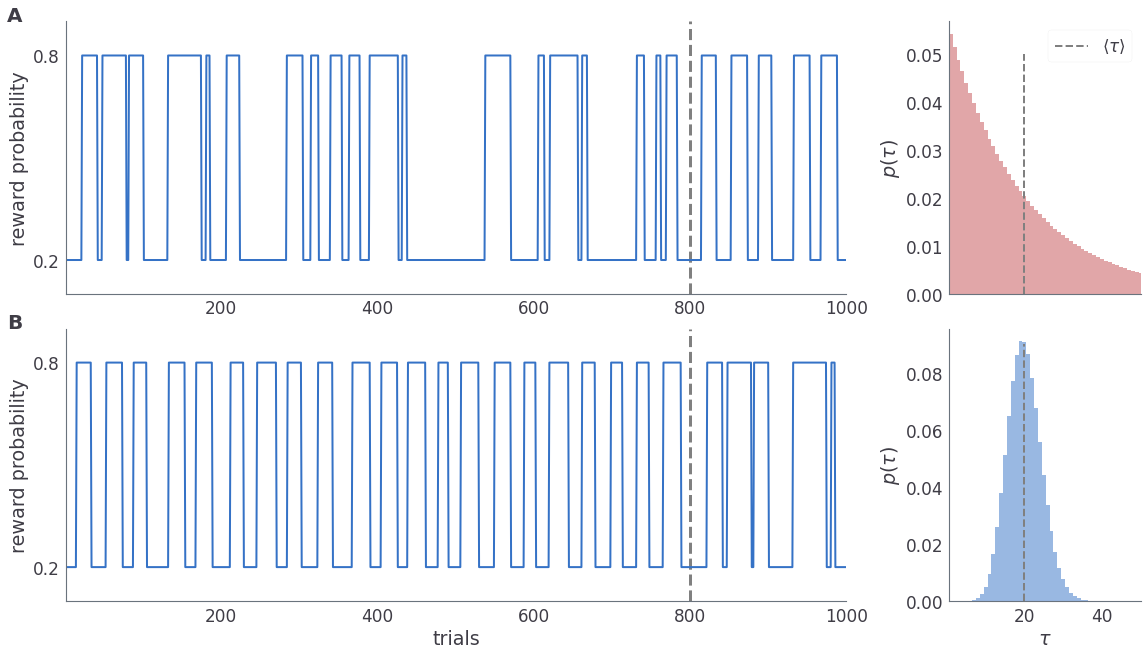

In [4]:
from scipy.special import loggamma
from jax import nn

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 9), sharex=True)
gs = axes[0, 0].get_gridspec()
# remove the underlying axes
for ax in axes[:, :-1].flatten():
    ax.remove()
axbig1 = fig.add_subplot(gs[0, :-1])
axbig2 = fig.add_subplot(gs[1, :-1])

trials = np.arange(1, len(Sirr) + 1)

axbig1.plot(trials, .6 * Sirr + .2, lw=2)
axbig1.vlines(800, .1, .9, lw=3, color='gray', linestyle='--')
axbig1.set_yticks([.2, .8])
axbig1.set_ylabel('reward probability')

axbig2.plot(trials, .6 * Sreg + .2, lw=2)
axbig2.vlines(800, .1, .9, lw=3, color='gray', linestyle='--')
axbig2.set_ylabel('reward probability')
axbig2.set_xlabel('trials')
axbig2.set_yticks([.2, .8])

axbig1.set_xlim([1, len(Sirr)])
axbig1.set_ylim([.1, .9])

axbig2.set_xlim([1, len(Sirr)])
axbig2.set_ylim([.1, .9])

mu = 19
color = ['r', 'b']
d = np.arange(1., 51.)
for i, nu in zip(range(3), [1., 10000.]):
    k = d - 1
    lbinom = loggamma(k + nu) - loggamma(d) - loggamma(nu)
    delta = mu / (mu + nu)
    p0 = nn.softmax(lbinom + k * np.log(delta) + nu * np.log(1-delta), -1)
    axes[i, -1].bar(d, p0, alpha = .5, color=color[i], width=1)
    axes[i, -1].set_xlim([.5, 50])
    
axes[0, -1].vlines(20, 0, 0.05, color='gray', linestyle='--', label=r'$\langle \tau \rangle$', lw=2)
axes[1, -1].vlines(20, 0, 0.09, color='gray', linestyle='--', lw=2)
axes[0, -1].legend()

axes[0, -1].set_ylabel(r'$p(\tau)$')
axes[1, -1].set_ylabel(r'$p(\tau)$')
axes[1, -1].set_xlabel(r'$\tau$')

fig.align_labels()
fig.tight_layout()
sns.despine(fig)

axes = [axbig1, axbig2]
for i in range(2):
    axes[i].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i].transAxes, size=20, weight='bold')

# fig.savefig('Fig1.pdf', bbox_inches='tight', transparent=True, dpi=300)

In the regular condition, shown at the bottom of the figure, the participants were exposed to a regular (predictable) reversals for 800 trials and then to an irregular sequence of reversals for 200 trials (same reversal rate but les predictable moment of reversals). In the irregular condition, shown at the top, the participant were first exposed to irregular reversals (for 800 trials) and then to a 200 trial long sequence of regular reversals. Note that the sequences after the regime change correspond to the first 200 trials of the alternative condition.

In [6]:
# mark subjects which generated less than 20 exploratory responses
expl_subs = (responses_data == 2).sum(0) > 20
expl_sub_num = np.arange(nsub)[expl_subs]
nexpl_sub_num = np.arange(nsub)[~expl_subs]
print(len(nexpl_sub_num))

38


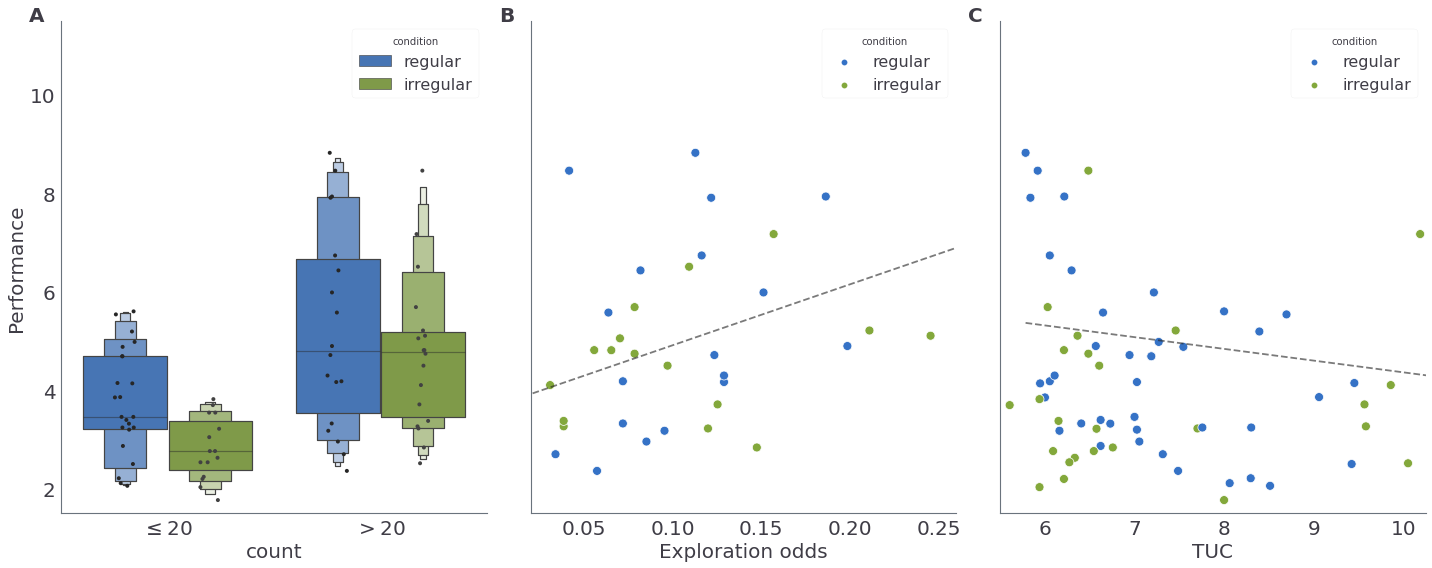

In [8]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=16)

cutoff = 100
perf = np.nanmean(correct_choices_data[cutoff:-200], -2)
states =  np.concatenate([Sreg[None].repeat(ns_reg, 0), Sirr[None].repeat(ns_irr, 0)], 0)
tuc = trials_until_correct(np.nan_to_num(correct_choices_data).T, states, τ=3).T

df = pd.DataFrame({'performance': perf/(1-perf), 
                   'TUC': np.nanmean(tuc[cutoff:-200], -2)})

df['exploration'] = np.nanmean(responses_data[cutoff:-200] == 2, -2)
df['ratio'] = df['exploration'] / (1 - df['exploration'])

df['condition'] = conditions.condition
df['count'] = r'$\leq 20$'
df.loc[expl_sub_num, 'count'] = r'$> 20$'

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

g = sns.stripplot(x="count", y="performance", data=df, hue='condition', size=4, color=".26", ax=axes[0], dodge=True)
sns.boxenplot(x='count', y='performance', data=df, hue='condition', ax=axes[0], showfliers=False, k_depth='full')
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles[:2], ['regular', 'irregular'], title='condition')

df_expl = df.iloc[expl_sub_num]
sns.scatterplot(x='ratio', y='performance', data=df_expl, hue='condition', ax=axes[1], s=80)
sns.regplot(x='ratio', y='performance', data=df_expl, color='k', ax=axes[1], ci=None, scatter_kws={'alpha': 0.}, line_kws={'linestyle': '--', 'alpha':.6});

sns.scatterplot(x='TUC', y='performance', data=df, hue='condition', ax=axes[2], s=80)
sns.regplot(x='TUC', y='performance', data=df_expl, color='k', ax=axes[2], ci=None, scatter_kws={'alpha': 0.}, line_kws={'linestyle': '--', 'alpha':.6});

axes[1].set_xlim([0.02, 0.26])
axes[2].set_xlim([5.5, 10.25])
axes[0].set_ylim([1.5, 11.5])

sns.despine(fig)
axes[0].set_ylabel('Performance')
axes[1].set_xlabel('Exploration odds')

for i in range(3):
    axes[i].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i].transAxes, size=20, weight='bold')
    
fig.align_labels()
fig.tight_layout()

fig.savefig('Fig3.pdf', transparent=True, dpi=300)

In [7]:
import glob
waics = {}
samples = {}
for filename in sorted(glob.glob('fit_waic_sample/fit_waic_sample_minf*.*')):
    fits = np.load(filename, allow_pickle=True)
    m = int(filename.split('_')[-1].split('.')[0].split('f')[-1])
    print(m, filename)
    waics[m] = fits['waic']
    samples[m] = fits['samples'].item()

waic_array = np.zeros((len(waics), nsub))
for m in sorted(waics.keys()):
    waic_array[m-1] = waics[m]

1 fit_waic_sample/fit_waic_sample_minf1.npz
10 fit_waic_sample/fit_waic_sample_minf10.npz
11 fit_waic_sample/fit_waic_sample_minf11.npz
12 fit_waic_sample/fit_waic_sample_minf12.npz
13 fit_waic_sample/fit_waic_sample_minf13.npz
14 fit_waic_sample/fit_waic_sample_minf14.npz
15 fit_waic_sample/fit_waic_sample_minf15.npz
16 fit_waic_sample/fit_waic_sample_minf16.npz
17 fit_waic_sample/fit_waic_sample_minf17.npz
18 fit_waic_sample/fit_waic_sample_minf18.npz
19 fit_waic_sample/fit_waic_sample_minf19.npz
2 fit_waic_sample/fit_waic_sample_minf2.npz
3 fit_waic_sample/fit_waic_sample_minf3.npz
4 fit_waic_sample/fit_waic_sample_minf4.npz
5 fit_waic_sample/fit_waic_sample_minf5.npz
6 fit_waic_sample/fit_waic_sample_minf6.npz
7 fit_waic_sample/fit_waic_sample_minf7.npz
8 fit_waic_sample/fit_waic_sample_minf8.npz
9 fit_waic_sample/fit_waic_sample_minf9.npz


In [4]:
fits = np.load('fit_waic_sample/dynpref_fit_sample_mixture.npz', allow_pickle=True)
samples_mixture = fits['samples'].item()

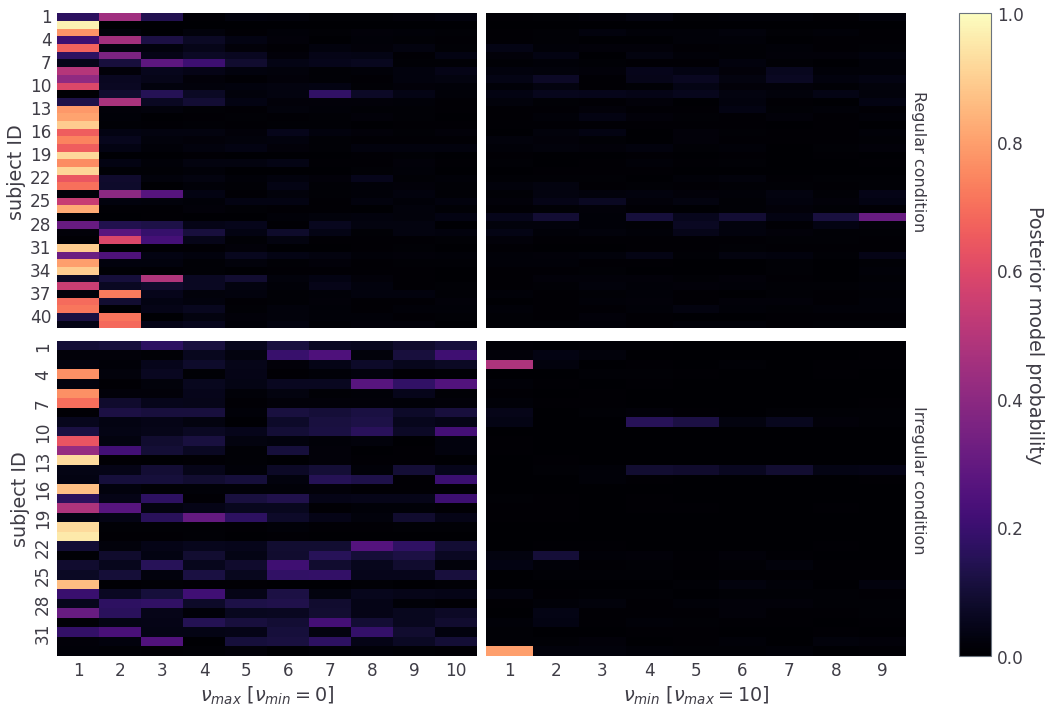

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex='col', sharey='row')
x_ticks = [list(range(1, 11)), list(range(1, 10))]
y_ticks = [list(range(1, ns_reg + 1)), list(range(1, ns_irr + 1))]
labels = [r'$\nu_{max}$ $\left[ \nu_{min}=0 \right]$', r'$\nu_{min}$ $\left[ \nu_{max}=10 \right]$']

d = 10  # number of models with fixed nu_min 
probs = samples_mixture['weights'].mean(0)

reg_cond = conditions.condition == 'regular'
irr_cond = conditions.condition == 'irregular'
cond = [reg_cond, irr_cond]

for i in range(2):
    for j in range(2):
        sns.heatmap(data=probs[cond[i], j*d:(j+1)*d], 
                    ax=axes[i, j], 
                    xticklabels=x_ticks[j],
                    cbar=False, 
                    vmin=0, 
                    vmax=1, 
                    cmap='magma')
    axes[i, 0].set_ylabel('subject ID')

axes[1, 0].set_xlabel(labels[0])
axes[1, 1].set_xlabel(labels[1])

axes[0, 0].yaxis.set_ticklabels(range(1, ns_reg + 1, 3))
axes[1, 0].yaxis.set_ticklabels(range(1, ns_irr + 1, 3))

axes[0, 1].text(9.1, 28, 'Regular condition', rotation=-90, fontsize=16);
axes[1, 1].text(9.1, 22, 'Irregular condition', rotation=-90, fontsize=16);

fig.tight_layout()

norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes)
cbar.ax.set_ylabel('Posterior model probability', rotation=-90, labelpad=20);
# fig.savefig('supp_Fig7-1.pdf', bbox_inches='tight', dpi=300)

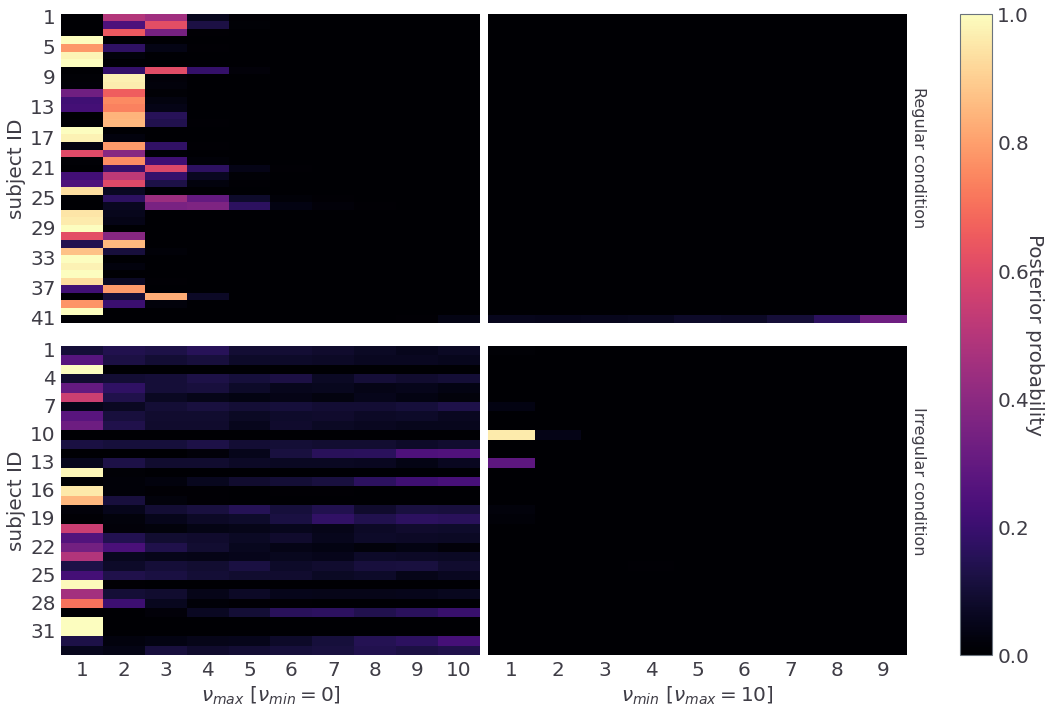

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex='col', sharey='row')
x_ticks = [list(range(1, 11)), list(range(1, 10))]
y_ticks = [list(range(1, ns_reg + 1)), list(range(1, ns_irr + 1))]
labels = [r'$\nu_{max}$ $\left[ \nu_{min}=0 \right]$', r'$\nu_{min}$ $\left[ \nu_{max}=10 \right]$']

d = 10  # number of models with fixed nu_min 
probs = softmax(waic_array, 0).T

for i in range(2):
    for j in range(2):
        sns.heatmap(data=probs[i*ns_reg:(i+1)*ns_reg, j*d:(j+1)*d], 
                    ax=axes[i, j], 
                    xticklabels=x_ticks[j],
                    cbar=False, 
                    vmin=0, 
                    vmax=1, 
                    cmap='magma')
    axes[i, 0].set_ylabel('subject ID')

axes[1, 0].set_xlabel(labels[0])
axes[1, 1].set_xlabel(labels[1])

axes[0, 0].yaxis.set_ticklabels(range(1, ns_reg + 1, 4))
axes[1, 0].yaxis.set_ticklabels(range(1, ns_irr + 1, 3))

axes[0, 1].text(9.1, 28, 'Regular condition', rotation=-90, fontsize=16);
axes[1, 1].text(9.1, 22, 'Irregular condition', rotation=-90, fontsize=16);

fig.tight_layout()

norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes)
cbar.ax.set_ylabel('Posterior probability', rotation=-90, labelpad=15);

# fig.savefig('supp_Fig7-1.pdf', bbox_inches='tight', dpi=300)

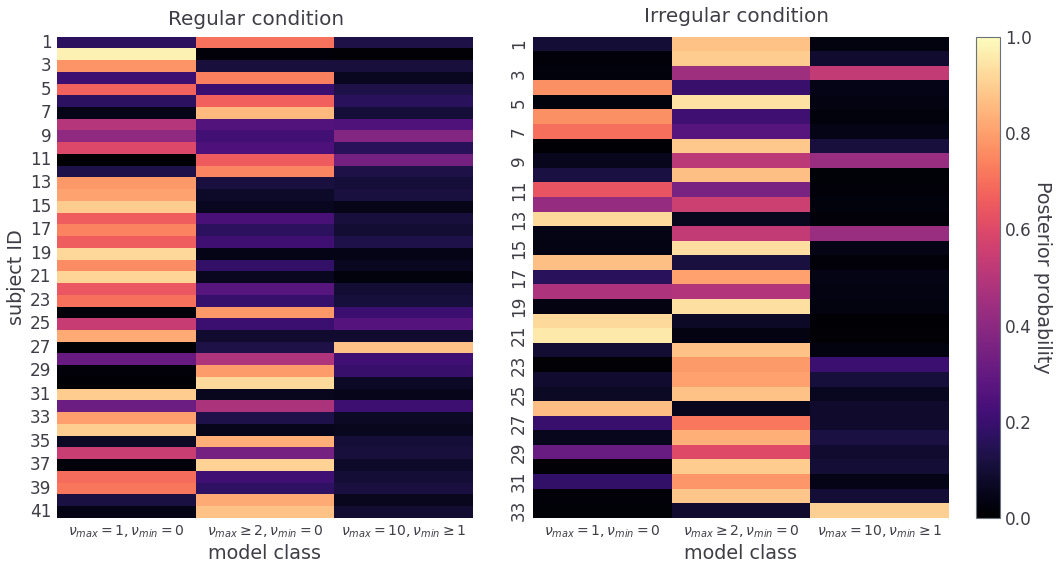

In [25]:
plt.rc('xtick', labelsize=14)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
x_ticks = [r'$\nu_{max}=1, \nu_{min}=0$', r'$\nu_{max} \geq 2, \nu_{min}=0$', r'$\nu_{max} = 10, \nu_{min} \geq 1$']

probs_red = np.stack([probs[:, 0], probs[:, 1:-9].sum(-1), probs[:, -9:].sum(-1)], -1)

for i in range(2):
    sns.heatmap(data=probs_red[cond[i], :], 
                ax=axes[i], 
                xticklabels=x_ticks,
                cbar=False, 
                vmin=0, 
                vmax=1, 
                cmap='magma')

axes[0].set_ylabel('subject ID')

axes[0].set_xlabel('model class')
axes[1].set_xlabel('model class')

axes[0].yaxis.set_ticklabels(range(1, ns_reg + 1, 2))
axes[1].yaxis.set_ticklabels(range(1, ns_irr + 1, 2))

axes[0].text(.8, -1, 'Regular condition', fontsize=20);
axes[1].text(.8, -1, 'Irregular condition', fontsize=20);

fig.tight_layout(w_pad=5.0)
norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes, pad=0.025)
cbar.ax.set_ylabel('Posterior probability', rotation=-90, labelpad=20);

# fig.savefig('Fig7.pdf', bbox_inches='tight', dpi=300)

In [26]:
n_reg = np.sum(probs[cond[0]].argmax(-1) > 0)
print('regular condition ', n_reg / ns_reg)

n_irr = np.sum(probs_red[cond[1]].argmax(-1) > 0)
print('irregular condition', n_irr / ns_irr)
(n_reg + n_irr)/nsub

regular condition  0.34146341463414637
irregular condition 0.7272727272727273


0.5135135135135135

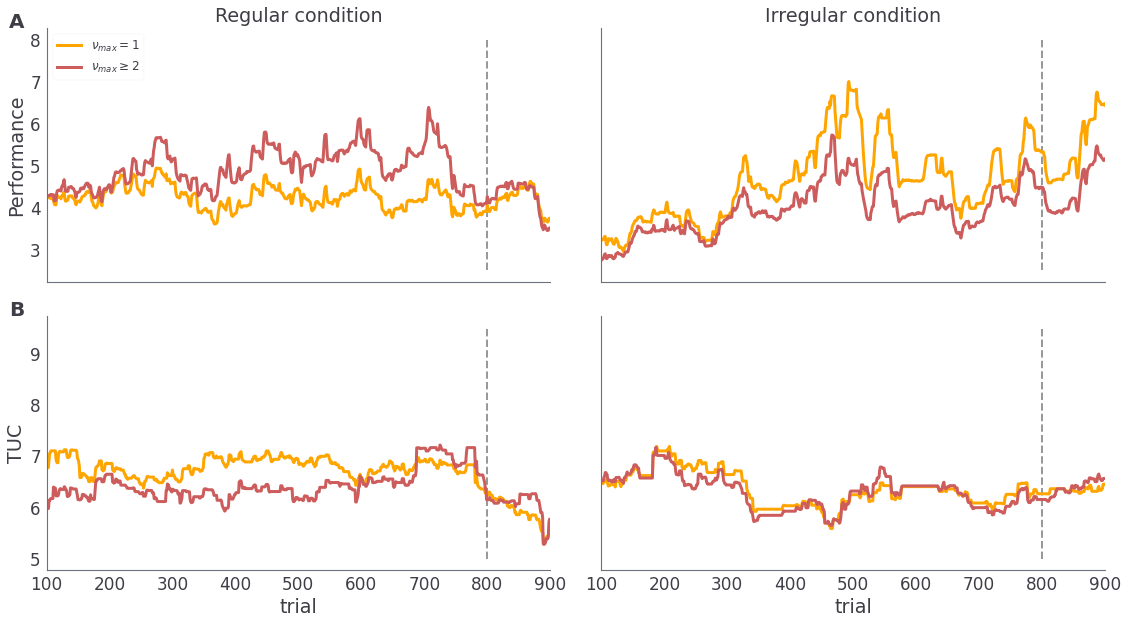

In [59]:
jtplot.style(theme='grade3', context='paper', fscale=1.6, grid=False)

ws = 201
locs1 = probs_red.argmax(-1) == 0
locs2 = probs_red.argmax(-1) >= 1
locs3 = probs_red.argmax(-1) == 2

fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')
trials = np.arange(101, 901)

states = []
for c in conditions.condition:
    if c == 'regular':
        states.append(Sreg)
    else:
        states.append(Sirr)
states = np.stack(states, 0)

tuc = trials_until_correct(np.nan_to_num(correct_choices_data).T, states, τ=3)
rolling_tuc = running_mean(tuc, ws=ws)
rolling_perf = performance(correct_choices_data, ws=ws)

regs = cond[0]
irrs = cond[1]
rp1 = rolling_perf[regs][locs1[regs], :].T
axes[0, 0].plot(trials, rp1.mean(-1), color='orange', lw=3, label=r'$\nu_{max}=1$');

rp11 = rolling_perf[regs][locs2[regs], :].T
axes[0, 0].plot(trials, rp11.mean(-1), color='indianred', lw=3, label=r'$\nu_{max}\geq 2$');

# rp12 = rolling_perf[regs][locs3[regs], :].T
# axes[0, 0].plot(trials, rp12.mean(-1), color='c', lw=3, label=r'$\nu_{min}\geq 1$');

rp2 = rolling_perf[irrs][locs1[irrs], :].T
axes[0, 1].plot(trials, rp2.mean(-1), color='orange', lw=3, label=r'$\nu_{max}=1$');

rp21 = rolling_perf[irrs][locs2[irrs], :].T
axes[0, 1].plot(trials, rp21.mean(-1), color='indianred', lw=3, label=r'$\nu_{max}\geq 2$');

# rp22 = rolling_perf[irrs][locs3[irrs], :].T
# axes[0, 1].plot(trials, rp22.mean(-1), color='c', lw=3, label=r'$\nu_{min}\geq 1$');

rl1 = rolling_tuc[regs][locs1[regs], :].T
axes[1, 0].plot(trials, rl1.mean(-1), color='orange', lw=3, label=r'$\nu_{max}=1$');

rl11 = rolling_tuc[regs][locs2[regs], :].T
axes[1, 0].plot(trials, rl11.mean(-1), color='indianred', lw=3, label=r'$\nu_{max}\geq 2$');

# rl12 = rolling_tuc[regs][locs3[regs], :].T
# axes[1, 0].plot(trials, rl12.mean(-1), color='c', lw=3, label=r'$\nu_{max}>1$');

rl2 = rolling_tuc[irrs][locs1[irrs], :].T
axes[1, 1].plot(trials, rl2.mean(-1), color='orange', lw=3, label=r'$\nu_{max}=1$');

rl21 = rolling_tuc[irrs][locs2[irrs], :].T
axes[1, 1].plot(trials, rl21.mean(-1), color='indianred', lw=3, label=r'$\nu_{max}\qeg 2$');

# rl22 = rolling_tuc[irrs][locs3[irrs], :].T
# axes[1, 1].plot(trials, rl22.mean(-1), color='c', lw=3, label=r'$\nu_{max}>1$');

for i in range(2):
    axes[0, i].vlines(800, 2.5, 8, color='gray', linestyle='--', lw=2, alpha=.8)
    axes[1, i].vlines(800, 5, 9.5, color='gray', linestyle='--', lw=2, alpha=.8)

# axes[0, 1].legend(loc=2, title='Model');
axes[0, 0].legend(loc=2, fontsize=12)

axes[0, 0].set_ylabel('Performance');
axes[1, 0].set_ylabel('TUC');
axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')
axes[1, 0].set_xlabel('trial')
axes[1, 1].set_xlabel('trial')
axes[1, 1].set_xlim([100, 900])

for i in range(2):
    axes[i, 0].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i, 0].transAxes, size=20, weight='bold')
    
fig.tight_layout()
sns.despine(fig)
# fig.savefig('Fig8.pdf', transparent=True, dpi=300)

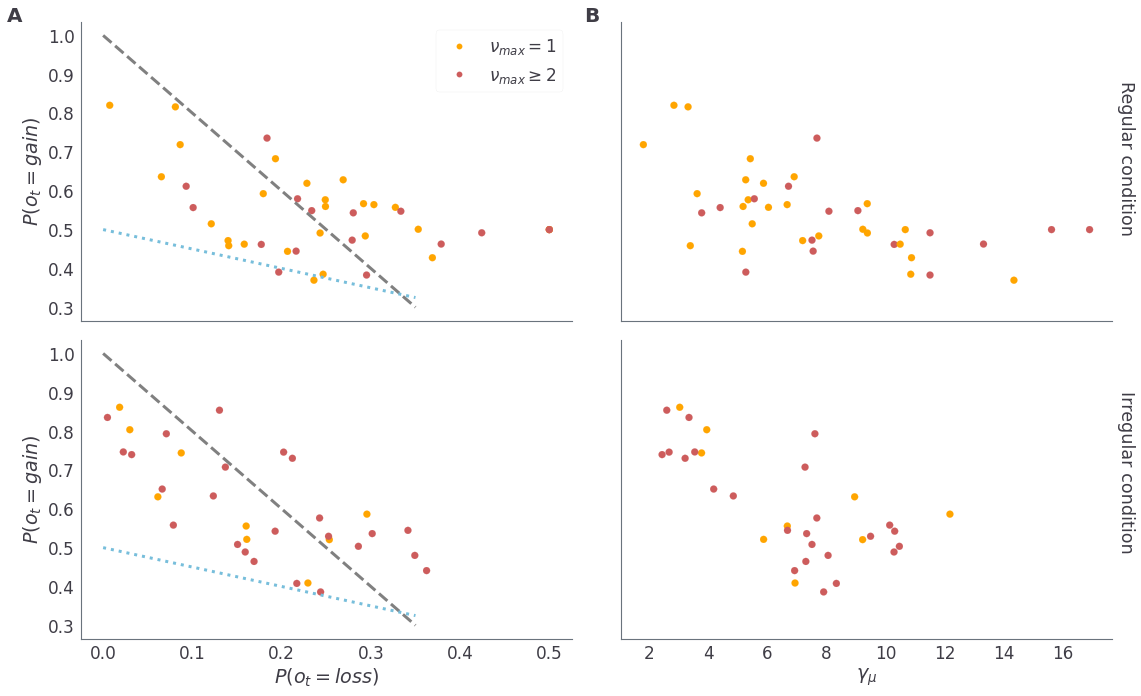

In [100]:
from matplotlib.colors import ListedColormap
jtplot.style(theme='grade3', context='paper', fscale=1.6, grid=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex='col', sharey='row')

cmap = ListedColormap(['orange', 'indianred'])

my_col_reg = []
for i in range(sum(cond[0])):
    if locs1[cond[0]][i]:
        my_col_reg.append(0)
    elif locs2[cond[0]][i]:
        my_col_reg.append(1)

my_col_irr = []
for j in range(sum(cond[1])):
    if locs1[cond[1]][j]:
        my_col_irr.append(0)
    elif locs2[cond[1]][j]:
        my_col_irr.append(1)
    
gammas = samples_mixture['mu']
lambdas = samples_mixture['lam0']/samples_mixture['lam0'].sum(-1, keepdims=True)
l1_m = np.mean(lambdas[..., 0], 0)
l2_m = np.mean(lambdas[..., 1], 0)
gmms = np.mean(gammas, 0)

x = np.array([.0, .35]) 
sct = axes[0, 0].scatter(l1_m[cond[0]], l2_m[cond[0]], s=50, c=my_col_reg, cmap=cmap)
axes[0, 0].plot(x, 1 - 2 * x, 'gray', linestyle='--', lw=3)
axes[0, 0].plot(x, (1 - x)/2, 'c', linestyle=':', lw=3)

axes[1, 0].scatter(l1_m[cond[1]], l2_m[cond[1]], s=50, c=my_col_irr, cmap=cmap)
axes[1, 0].plot(x, 1 - 2 * x, 'gray', linestyle='--', lw=3)
axes[1, 0].plot(x, (1 - x)/2, 'c', linestyle=':', lw=3)

axes[0, 1].scatter(gmms[cond[0]], l2_m[cond[0]], s=50, c=my_col_reg, cmap=cmap)
axes[1, 1].scatter(gmms[cond[1]], l2_m[cond[1]], s=50, c=my_col_irr, cmap=cmap)

axes[0, 0].set_ylabel(r'$P(o_t=gain)$')
axes[1, 0].set_ylabel(r'$P(o_t=gain)$')
axes[1, 0].set_xlabel(r'$P(o_t=loss)$')
axes[1, 1].set_xlabel(r'$\gamma_{\mu}$')

axes[0, 0].legend(handles=sct.legend_elements()[0], labels=[r'$\nu_{max}=1$', r'$\nu_{max} \geq 2$',r'$\nu_{min} \geq 1$'], loc=0)

axes[0, 0].text(-.15, 1., string.ascii_uppercase[0], transform=axes[0, 0].transAxes, size=20, weight='bold')
axes[0, 1].text(-.075, 1., string.ascii_uppercase[1], transform=axes[0, 1].transAxes, size=20, weight='bold')
sns.despine(fig)

axes[0, 1].text(1.01, .3, 'Regular condition', rotation=-90, transform=axes[0, 1].transAxes);
axes[1, 1].text(1.01, .3, 'Irregular condition', rotation=-90, transform=axes[1, 1].transAxes);

fig.tight_layout()

Old code starts here. Think whether to keep it and include it in the paper.

In [ ]:
from scipy import io
# load experiment and generate observations
data = io.loadmat('../main/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

runs = 1

outcomes1 = jnp.concatenate([(Oreg[:, None].repeat(runs, -2) + 1)//2, 
                            (Oirr[:, None].repeat(runs, -2) + 1)//2], -2)
outcomes2 = jnp.concatenate([Sreg[:, None].repeat(runs, -1) + 2, 
                             Sirr[:, None].repeat(runs, -1) + 2], -1)[..., None]

outcomes = jnp.concatenate([outcomes1, outcomes2], -1)

subs = jnp.array(range(2 * runs))
def process(t, responses):
    return outcomes[t, subs, responses]

In [9]:
# POMDP simulator
def simulator(process, agent, seed=0, **model_kw):
    def sim_fn(carry, t):
        rng_key, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = agent.action_selection(_rng_key, prior, **model_kw)
        
        outcomes = process(t, choices)
        
        posterior = agent.learning(outcomes, choices, prior)
                
        return (rng_key, posterior), {'outcomes': outcomes, 
                                      'choices': choices,
                                      'beliefs': prior}
    
    rng_key = random.PRNGKey(seed)
    _, sequence = lax.scan(sim_fn, (rng_key, agent.prior), jnp.arange(len(outcomes)))
    sequence['outcomes'].block_until_ready()
    
    return sequence

In [ ]:
N = outcomes.shape[-2]
sequences = {}
for nu in [1, 10]:
    agent = Agent(N, nu)
    sequences[nu] = simulator(process, agent, U=jnp.array([-1., 1., -.5, -.5]))

In [4]:
trials = 1000
def get_reversal_statistics(responses, corrects, states, nsub, delta=200):

    A = responses.T == 2
    C = corrects.T

    reversal = np.abs(np.diff(states.flatten())).astype(bool)
    trials = np.arange(1, 1000)[reversal]
    perf = {}
    expl = {}
    for t in trials:
        block = np.long(np.floor(t/delta))
        perf.setdefault(block, [])
        perf[block].append(C[:,t-10:t+10])
        
        expl.setdefault(block, [])
        expl[block].append(A[:,t-10:t+10])
        
    for block in expl:
        perf[block] = np.nanmean(np.stack(perf[block]), 0)
        expl[block] = np.nanmean(np.stack(expl[block]), 0)
    
    return perf, expl

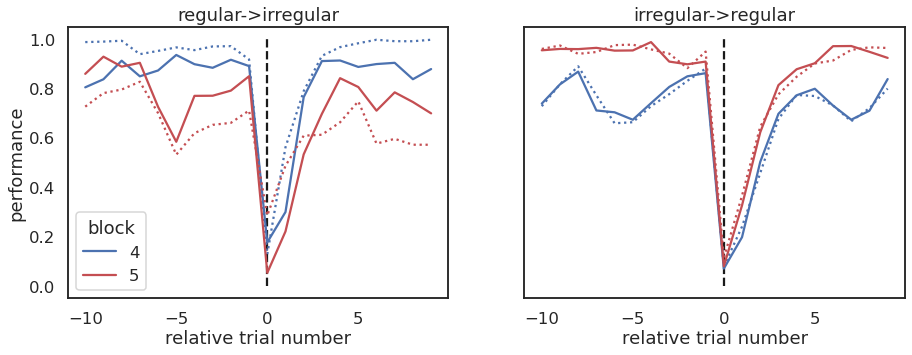

In [14]:
# plot superimposed behavioural and simulated response data
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
color = ['b', 'r']
for block in range(3,5):
    axes[0].plot(t, np.mean(np.vstack(reg_perf[block]), 0), label=block+1, color=color[block-3])
    axes[0].plot(t, np.mean(np.vstack(reg_perf1[block]), 0), ':', color=color[block-3])

    axes[1].plot(t, np.mean(np.vstack(irr_perf[block]), 0), color=color[block-3])
    axes[1].plot(t, np.mean(np.vstack(irr_perf2[block]), 0), ':', color=color[block-3])

axes[0].legend(title='block');
axes[0].vlines(0, 0., 1., 'k', linestyle='--');
axes[1].vlines(0, 0., 1., 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('performance')
fig.savefig('performance_trial.svg', bbox_inches='tight', transparent=True, dpi=300)